# Preliminaries
Uncomment and run the following to install required R packages if necessary

In [1]:
#install.packages('ez')
#install.packages('ggplot2')
#update.packages(checkBuilt=TRUE) 

Load required packages

In [2]:
library(ez, pos=13)
library(car)
library(ggplot2)

Decide whether we want to analyse data in which hits and false alarms were corrected the way reported in the manuscript (replace hits, false alamrs that are excactly zero or one with 0.01 and 0.99 respectively) or by the method proposed by Snodgrass & Corwin 1988.

In [3]:
hfacorrection = 'regular';
#hfacorrection = 'snodgrass&corwin1988';
fname = paste("outputs/sc_", hfacorrection, ".txt", sep="")

Load data as aggregated by `1_MATALAB_LoadAndAggregateData.ipynb`

In [4]:
sc <- read.table(fname,header=TRUE, sep=",", na.strings="NaN", dec=".", strip.white=TRUE)

In [5]:
#names(sc)
str(sc)

'data.frame':	116 obs. of  21 variables:
 $ subject               : int  1 1 1 1 2 2 2 2 3 3 ...
 $ visibility            : int  4 3 2 1 4 3 2 1 4 3 ...
 $ Visibility            : Factor w/ 4 levels "above_th","at_th",..: 1 2 3 4 1 2 3 4 1 2 ...
 $ run                   : int  1 2 3 4 1 2 3 4 1 2 ...
 $ belowth_vs_invisible  : int  0 1 0 0 0 1 0 0 0 1 ...
 $ threshold_vs_invisible: int  0 0 1 0 0 0 1 0 0 0 ...
 $ visible_vs_invisble   : int  0 0 0 1 0 0 0 1 0 0 ...
 $ pGOr                  : num  0.99 0.938 0.472 0.5 0.99 0.875 0.611 0.194 0.99 0.938 ...
 $ pGOp                  : num  0.01 0.125 0.611 0.528 0.01 0.625 0.472 0.389 0.25 0.562 ...
 $ dprime_conditioning   : num  4.653 2.684 -0.352 -0.07 4.653 ...
 $ stim_r                : Factor w/ 8 levels "briefcase","bucket",..: 6 1 4 5 1 4 2 6 6 1 ...
 $ stim_p                : Factor w/ 8 levels "briefcase","bucket",..: 3 8 2 7 7 3 8 5 7 5 ...
 $ d_post_r              : num  NA 2.432 -1.176 0.289 NA ...
 $ d_post_p              : n

define some columns as factors

In [6]:
sc$subject <- factor(sc$subject)

# Post Threshold Test
## One-way repeated measures Anova of the factor Detectability on discrimination performance in the threshold test (Section 3.1. in the Manuscript, 1st paragraph )

In [7]:
anova1= ezANOVA(data=sc, dv=.(dprime_post_av), wid=.(subject), within=.(Visibility), type=3, detailed=TRUE)

In [8]:
anova1$'ANOVA'

Effect,DFn,DFd,SSn,SSd,F,p,p<.05,ges
(Intercept),1,28,541.4083,13.78857,1099.4201,5.135573e-24,*,0.9494652
Visibility,3,84,249.5975,15.02763,465.0587,3.423194e-52,*,0.8964986


In [9]:
anova1$'Mauchly\'s Test for Sphericity'

,Effect,W,p,p<.05
2,Visibility,0.5159999,0.003397873,*


In [10]:
anova1$'Sphericity Corrections'

,Effect,GGe,p[GG],p[GG]<.05,HFe,p[HF],p[HF]<.05
2,Visibility,0.6946956,5.291369e-37,*,0.7516427,7.738512e-40,*


Adjust dofs accordingly

In [11]:
eps_vis = anova1$'Sphericity Corrections'[1,5];
F_vis = anova1$ANOVA[2,6]
Fn_vis = anova1$ANOVA[2,2]*eps_vis
Fd_vis = anova1$ANOVA[2,3]*eps_vis
p_vis = (1-pf(F_vis, Fn_vis,Fd_vis))  
sprintf("F(%.3f,%.3f)  = %.3f, p = %e, HF epsilon = %.2f)", Fn_vis, Fd_vis, F_vis, p_vis, eps_vis)

[1] "F(2.255,63.138)  = 465.059, p = 0.000000e+00, HF epsilon = 0.75)"

Pairwise post-hoc t-tests of neighboring Visibility Levels

In [12]:
varlabels <-c("<<th", "<th", "@th", ">th")
for (i in 1:3){
  var1 <- sc[sc$visibility==i+1, "dprime_post_av"]
  var2 <- sc[sc$visibility==i, "dprime_post_av"]
  # do the t-test
  result <- t.test(var1, var2, paired=TRUE)
  
  # calcualte cohen's d (mean differences/ standard deviations of mean differences)
  cohensd <- mean(var1-var2)/sd(var1-var2)

  # format the output
  output <- sprintf('dprimes post: M(SD) %s: %.2f(%.2f), M(SD) %s = %.2f(%.2f), t(%2.0f)= %.3f, p = %.3e, Cohen\'s d: %.2f', varlabels[i+1], mean(var1), sd(var1), varlabels[i], mean(var2), sd(var2), result$parameter, result$statistic, result$p.value, cohensd)
  print(output)
}

[1] "dprimes post: M(SD) <th: 1.19(0.60), M(SD) <<th = 0.56(0.42), t(28)= 7.627, p = 2.620e-08, Cohen's d: 1.42"
[1] "dprimes post: M(SD) @th: 2.51(0.64), M(SD) <th = 1.19(0.60), t(28)= 14.288, p = 2.186e-14, Cohen's d: 2.65"
[1] "dprimes post: M(SD) >th: 4.39(0.28), M(SD) @th = 2.51(0.64), t(28)= 13.270, p = 1.340e-13, Cohen's d: 2.46"


## One-way repeated measures Anova of the factor Visibility on Subjective Awareness Ratings obtained after each run in the conditioning experiment (Section 3.1. in the Manuscript, 2nd paragraph )

As we have missing data of these awareness ratings in two subjects, we have to remove these first

In [13]:
sc$iscomplete <- FALSE 
for (s in unique(sc$subject)){
  hasNA = unique(is.na(sc$subjective_awareness) & sc$subject == s)
  if (length(hasNA) < 2){ # all good
    sc$iscomplete[sc$subject == s] = TRUE
  }
  rm(hasNA)
}

# save complete cases in new data frame
sc_ <- sc[sc$iscomplete,]

# now, it seem that we have to refresh that subject factor for some reason 
sc_$subject <- factor(sc_$subject)

Then, we can do the Anova similar to the above:

In [14]:
anova2= ezANOVA(data=sc_, dv=.(subjective_awareness), wid=.(subject), within=.(Visibility), type=3, detailed=TRUE)
anova2$'ANOVA'

Effect,DFn,DFd,SSn,SSd,F,p,p<.05,ges
(Intercept),1,26,3072.000,208.500,383.07914,4.412140e-17,*,0.8695069
Visibility,3,78,924.963,252.537,95.22974,5.301354e-26,*,0.6673614


In [15]:
anova2$'Mauchly\'s Test for Sphericity'

,Effect,W,p,p<.05
2,Visibility,0.9831861,0.9947879,


... all good, no corrections of dofs needed here, and we can go on with pariwise comparisons of neighboring visibility levels as above

In [16]:
varlabels <-c("<<th", "<th", "@th", ">th")
for (i in 1:3){
  var1 <- sc_[sc_$visibility==i+1, "subjective_awareness"]
  var2 <- sc_[sc_$visibility==i, "subjective_awareness"]
  # do the t-test
  result <- t.test(var1, var2, paired=TRUE)
  
  # calcualte cohen's d (mean differences/ standard deviations of mean differences)
  cohensd <- mean(var1-var2)/sd(var1-var2)

  # format the output
  output <- sprintf('subj. Awareness M(SD) %s: %.2f(%.2f), M(SD) %s = %.2f(%.2f), t(%2.0f)= %.3f, p = %.3e, Cohen\'s d: %.2f', varlabels[i+1], mean(var1), sd(var1), varlabels[i], mean(var2), sd(var2), result$parameter, result$statistic, result$p.value, cohensd)
  print(output)
}

[1] "subj. Awareness M(SD) <th: 3.67(2.51), M(SD) <<th = 1.93(2.38), t(26)= 3.445, p = 1.948e-03, Cohen's d: 0.66"
[1] "subj. Awareness M(SD) @th: 6.00(2.29), M(SD) <th = 3.67(2.51), t(26)= 4.608, p = 9.461e-05, Cohen's d: 0.89"
[1] "subj. Awareness M(SD) >th: 9.74(0.71), M(SD) @th = 6.00(2.29), t(26)= 7.905, p = 2.210e-08, Cohen's d: 1.52"


## 2 way repeated measures ANOVA of Conditioning Experiment

In [17]:
#load data produced by MATLAB Load and Aggregate Notebook
fname = paste("outputs/visibilityXreward", hfacorrection, ".txt", sep = "")
sc <- read.table(fname,header=TRUE, sep=",", na.strings="NA", dec=".", strip.white=TRUE)

# convert some columns to factors
sc$visibility <- factor(sc$visibility, labels = c(">th", "@th", "<th", "<<th" )) 
sc$reward <- factor(sc$reward, labels = c("rewarding", "punishing"))
sc$subject <- factor(sc$subject)

# look at the first 10 rows
head(sc,10)

Pgo,subject,visibility,reward
0.99000,1,>th,rewarding
0.01000,1,>th,punishing
0.93750,1,@th,rewarding
0.12500,1,@th,punishing
0.47222,1,<th,rewarding
0.61111,1,<th,punishing
0.50000,1,<<th,rewarding
0.52778,1,<<th,punishing
0.99000,2,>th,rewarding
0.01000,2,>th,punishing


### Do a similar plot to what is shown in Figure 4

As we use Matlab for all the figures, this is merely a sanity check.

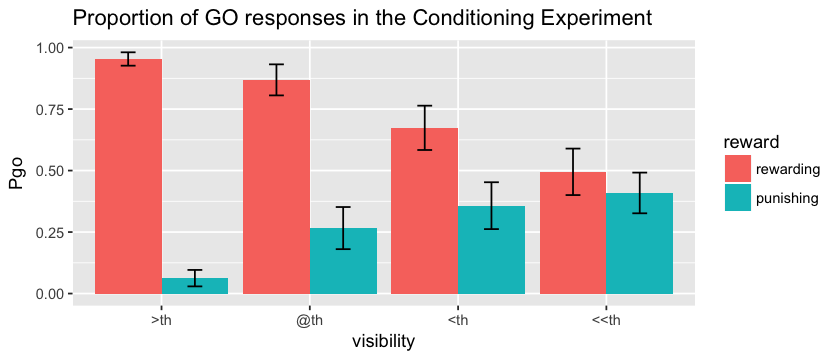

In [18]:
options(repr.plot.width=7, repr.plot.height=3)
plotData2 = ggplot(sc,aes(visibility, Pgo, fill=reward))
plotData2 + stat_summary(fun.y = mean, geom="bar", position="dodge") + 
    stat_summary(fun.data = mean_cl_normal, geom = "errorbar", position = position_dodge(width=0.90), width = 0.2) + 
    ggtitle("Proportion of GO responses in the Conditioning Experiment")

### compute the 2 x 4 ANOVA using ezANOVA

In [19]:
# do 2x4 ANOVA
anova= ezANOVA(data=sc, dv=.(Pgo), wid=.(subject), within=.(visibility, reward), type=3, detailed=TRUE)
anova$'ANOVA'

Effect,DFn,DFd,SSn,SSd,F,p,p<.05,ges
(Intercept),1,28,60.5178809,1.587580,1067.347907,7.695052e-24,*,0.87144246
visibility,3,84,0.3885731,2.318909,4.691882,4.446895e-03,*,0.04170879
reward,1,28,13.0300970,1.522493,239.635097,2.960831e-15,*,0.59341386
visibility:reward,3,84,5.3059788,3.498779,42.462646,8.464578e-17,*,0.37277476


In [20]:
anova$'Mauchly\'s Test for Sphericity'

,Effect,W,p,p<.05
2,visibility,0.6060807,0.02015008,*
4,visibility:reward,0.7557591,0.18740807,


In [21]:
anova$'Sphericity Corrections'

,Effect,GGe,p[GG],p[GG]<.05,HFe,p[HF],p[HF]<.05
2,visibility,0.7955833,8.590124e-03,*,0.8747522,6.650533e-03,*
4,visibility:reward,0.8716241,6.203850e-15,*,0.9694823,2.348051e-16,*


In [22]:
# get Huynh-Feldt corrected dofs, p-vals and episilon for main effect visibility
# and print the result with the corrected Values
eps_vis = anova$'Sphericity Corrections'[1,5];
F_vis = anova$ANOVA[2,6]
Fn_vis = anova$ANOVA[2,2]*eps_vis
Fd_vis = anova$ANOVA[2,3]*eps_vis
p_vis = (1-pf(F_vis, Fn_vis,Fd_vis))
sprintf("F(%.3f,%.3f)  = %.3f, p = %.5f, HF epsilon = %.2f)", Fn_vis, Fd_vis, F_vis, p_vis, eps_vis)

[1] "F(2.624,73.479)  = 4.692, p = 0.00665, HF epsilon = 0.87)"

### post hoc t-Tests of proportion of go punishing verus rewarding at each level of visibility

In [23]:
# loop over visibility levels
varlabels <-c(">th", "@th", "<th", "<<th")
for (i in 1:4){
  
  # select data
  var1 <- sc[sc$visibility==varlabels[i] & sc$reward=="rewarding", "Pgo"]
  var2 <- sc[sc$visibility==varlabels[i] & sc$reward=="punishing", "Pgo"]
  # do the t-test
  result <- t.test(var1, var2, paired=TRUE)
  
  # calcualte cohen's d (mean differences/ standard deviations of mean differences)
  cohensd <- mean(var1-var2)/sd(var1-var2)

  # format the output
  print(sprintf("%s: M(SD) rewarding: %.2f(%.2f), M(SD) punishing = %.2f(%.2f), t= %.3f, p = %e, Cohen\'s d: %.2f", varlabels[i],mean(var1), sd(var1), mean(var2), sd(var2), result$statistic, result$p.value, cohensd))
}

[1] ">th: M(SD) rewarding: 0.95(0.07), M(SD) punishing = 0.06(0.09), t= 39.460, p = 4.339094e-26, Cohen's d: 7.33"
[1] "@th: M(SD) rewarding: 0.87(0.17), M(SD) punishing = 0.27(0.23), t= 9.878, p = 1.262472e-10, Cohen's d: 1.83"
[1] "<th: M(SD) rewarding: 0.67(0.24), M(SD) punishing = 0.36(0.25), t= 4.508, p = 1.063942e-04, Cohen's d: 0.84"
[1] "<<th: M(SD) rewarding: 0.49(0.25), M(SD) punishing = 0.41(0.22), t= 1.516, p = 1.407559e-01, Cohen's d: 0.28"
